Разберемся с перцентилями и распределениями которые можно использовать в деревьях решений

In [20]:
from scipy.stats import lognorm, norm
import scipy
import numpy as np
import matplotlib.pyplot as plt

Начнем с нормального распределения

Нормальное распределение - непрерывное распределение вероятностей с пиком в центре и симметричными боковыми сторонами, которое в одномерном случае задаётся функцией плотности вероятности, совпадающей с функцией Гаусса:

$$f(x) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{(x - \mu)^2}{2\sigma^2}}$$

функция распределения

$$\Phi\left(\frac{x-\mu}{\sigma}\right) = \frac{1}{2}\left[1 + \operatorname{erf}\left( \frac{x-\mu}{\sigma\sqrt{2}}\right)\right]$$

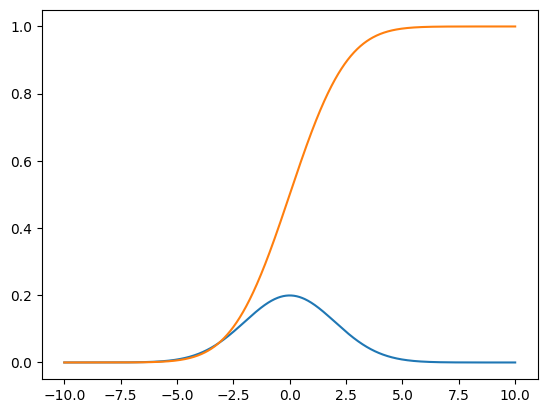

In [18]:
x = np.linspace(-10, 10, 1000)
ndist = norm(loc=-0, scale=2)

pdf = ndist.pdf(x)
cdf = ndist.cdf(x)

plt.plot(x, pdf)
plt.plot(x, cdf)

plt.show()


In [22]:
# проверим, что интеграл функции плотности распределения вероятности равен 1
print(np.trapezoid(pdf, x))
print(scipy.integrate.simpson(pdf, x=x))

0.9999994265727195
0.9999994266967668


In [25]:
# по известному распределению легко подсчитать перцентили
print(f'p10 = {ndist.ppf(0.1)}')
print(f'p50 = {ndist.ppf(0.5)}')
print(f'p90 = {ndist.ppf(0.9)}')

p10 = -2.5631031310892007
p50 = 0.0
p90 = 2.5631031310892007


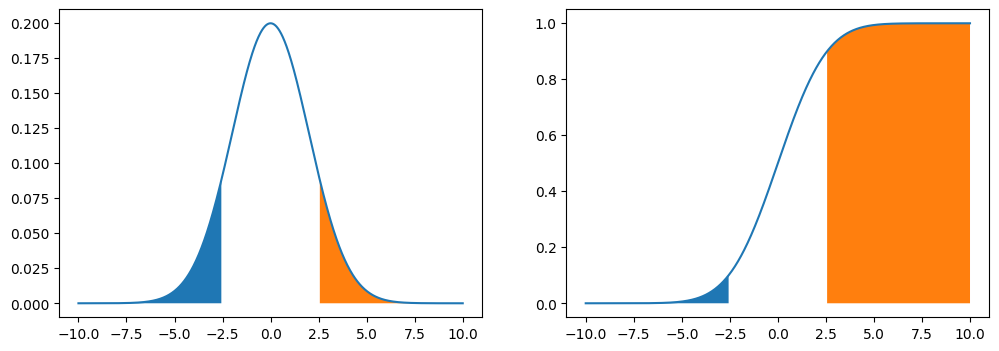

In [36]:

def plot_dist(ndist, p1=0.1, p2=0.9, xmin=-10, xmax=10, points=1000):
    x = np.linspace(xmin, xmax, points)

    v1 = ndist.ppf(p1)
    v2 = ndist.ppf(p2)

    pdf = ndist.pdf(x)
    cdf = ndist.cdf(x)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(x, pdf)

    x_p1 = np.linspace(xmin, v1, points)
    ax1.fill_between(x_p1, ndist.pdf(x_p1))

    x_p2 = np.linspace(v2, xmax, points)
    ax1.fill_between(x_p2, ndist.pdf(x_p2))


    ax2.plot(x, cdf)
    ax2.fill_between(x_p1, ndist.cdf(x_p1))
    ax2.fill_between(x_p2, ndist.cdf(x_p2))

    plt.show()

ndist = norm(loc=-0, scale=2)
plot_dist(ndist)

Нормальное распределение задается двумя параметрами - $\mu$ и $\sigma$, где $\mu$ - математическое ожидание (среднее значение), а $\sigma$ - стандартное отклонение.

Для нормального распределения легко вычислить параметры распределения по двум перцентилям.

$$
\mu = \frac{x_2 - x_1}{\phi^{-1}(p_2) - \phi^{-1}(p_1)} 
$$
$$
\sigma = \frac{x_1\phi^{-1}(p_2) - x_2\phi^{-1}(p_1)}{\phi^{-1}(p_2) - \phi^{-1}(p_1)}
$$

здесь $\phi^{-1}$ - обратная функция к `сdf(x)`, которая принимает значение в диапазоне от 0 до 1 и возвращает значение в диапазоне от -inf до inf.

In [33]:
def norm_from_percentiles(x1, p1, x2, p2):
    """ 
    возвращает параметры нормального распределения, заданные двумя перцентилями и значением в диапазоне от 0 до 1
    
            P(X < p1) = x1
            P(X < p2) = x2
    """
    p1ppf = norm.ppf(p1)
    p2ppf = norm.ppf(p2)

    location = ((x1 * p2ppf) - (x2 * p1ppf)) / (p2ppf - p1ppf)
    scale = (x2 - x1) / (p2ppf - p1ppf)

    return norm(loc=location, scale=scale)

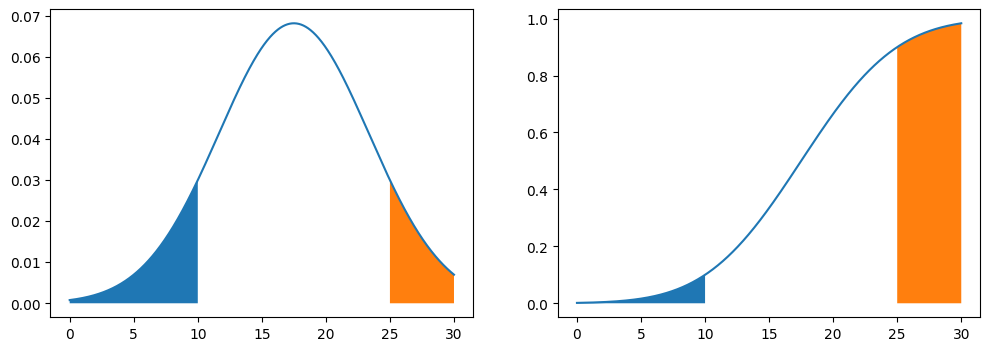

In [45]:
p10 = 10
p90 = 25

ndist2 = norm_from_percentiles(p10, 0.1, p90, 0.9)

plot_dist(ndist2, xmin=0, xmax=30)

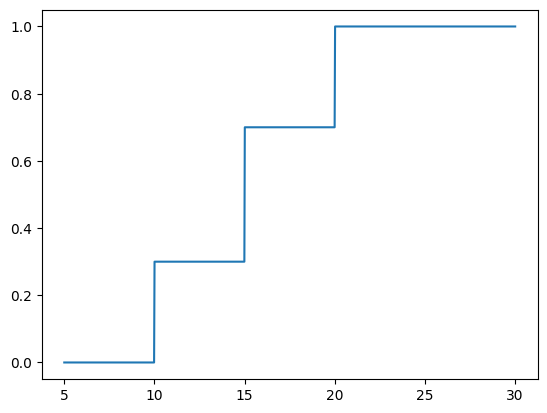

In [68]:
from scipy import stats
xk = ( 10, 15, 20)
pk = ( 0.3, 0.4, 0.3)
custm = stats.rv_discrete(name='custm', values=(xk, pk))

x = np.linspace(5, 30, 1000)
plt.plot(x, custm.cdf(x))

In [91]:
ndist2.expect( ub=ndist2.ppf(0.3), conditional=True)

np.float64(10.71735028952346)

In [83]:
x_discrete

(np.float64(14.431060792985754),
 np.float64(20.56893920701424),
 np.float64(22.42540403484621))

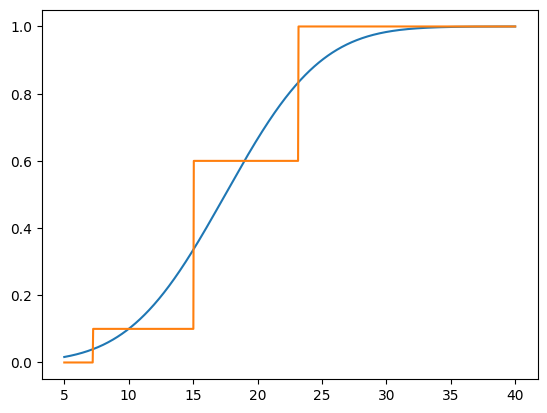

In [96]:
p10 = 10
p90 = 25

ndist2 = norm_from_percentiles(p10, 0.1, p90, 0.9)

x_discrete = (ndist2.expect(ub=ndist2.ppf(0.1), conditional=True), 
              ndist2.expect(lb=ndist2.ppf(0.1), ub=ndist2.ppf(0.6), conditional=True), 
              ndist2.expect(lb=ndist2.ppf(0.6), conditional=True))
p_discrete = (0.1, 0.5, 0.4)
ndist2_discrete = stats.rv_discrete(name='ndist2_discrete', values=(x_discrete, p_discrete))

x = np.linspace(5, 40, 1000)
plt.plot(x, ndist2.cdf(x))
plt.plot(x, ndist2_discrete.cdf(x))

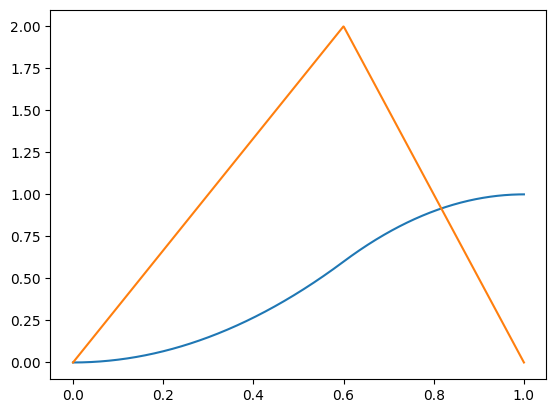

In [108]:
d = stats.triang(c=0.6)

x = np.linspace(0, 1, 1000)
plt.plot(x, d.cdf(x))
plt.plot(x, d.pdf(x))

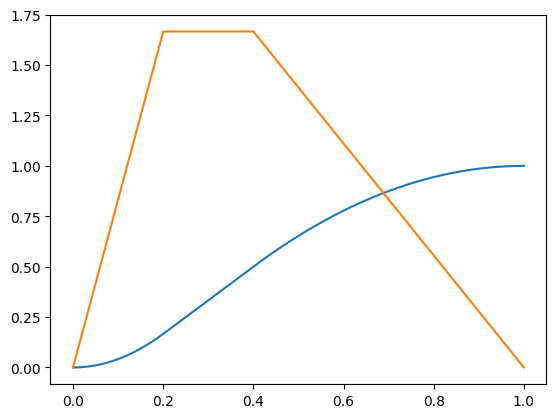

In [109]:
d = stats.trapezoid(c=0.2, d=0.4)

x = np.linspace(0, 1, 1000)
plt.plot(x, d.cdf(x))
plt.plot(x, d.pdf(x))